In [67]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [4]:
def plot_timeseries(df):
    plt.plot(df)
    plt.show()

Plot the timeseries from above

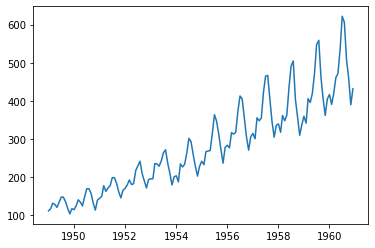

In [5]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [18]:
df['roll_mean'] = df['Passengers'].rolling(12).mean()

df['roll_std'] = df['Passengers'].rolling(12).std()


Plot two timeseries:
- with rolling mean 
- with rolling std

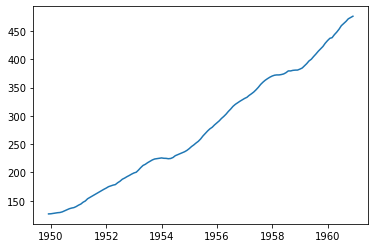

In [14]:
plot_timeseries(df['roll_mean'])

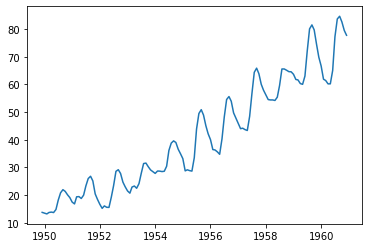

In [15]:
plot_timeseries(df['roll_std'])

Test the stationarity of all timeseries

In [9]:
adfuller(df['Passengers'])

(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [22]:
df['roll_mean']=df['roll_mean'].fillna(0)
df['roll_std']=df['roll_std'].fillna(0)

In [23]:
adfuller(df['roll_mean'])

(-1.2389070714766601,
 0.656639046818358,
 2,
 141,
 {'1%': -3.4776006742422374,
  '5%': -2.882265832283648,
  '10%': -2.5778219289774156},
 357.5007877733899)

In [24]:
adfuller(df['roll_std'])

(-0.1043418624669148,
 0.9490043462827934,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 495.36681891079644)

Transform the original timeseries with logarithm

In [25]:
df['logPass'] = np.log(df['Passengers'])

In [41]:
df.logPass.isna().sum()

0

Plot transformed timeseries

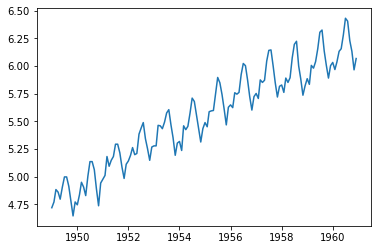

In [26]:
plot_timeseries(df['logPass'])

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [27]:
adfuller(df['logPass'])

(-1.7170170891069625,
 0.4223667747703904,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -445.3990312497209)

In [33]:
from sklearn.linear_model import LinearRegression
y = df['logPass'].values
X = [i for i in range(0, len(df))]
X = np.reshape(X,(len(X),1))
model = LinearRegression()
model.fit(X,y)
trend = model.predict(X)

In [34]:
detrended = [df['logPass'][i]-trend[i] for i in range(0, len(df['Passengers']))]

In [36]:
detrended[:5]

[-0.10521779270557463,
 -0.0630804212766991,
 0.03898849510231184,
 0.00595059513591778,
 -0.06811964537070825]

In [37]:
adfuller(detrended)

(-2.260661989631702,
 0.18496919097990328,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -447.70220390617067)

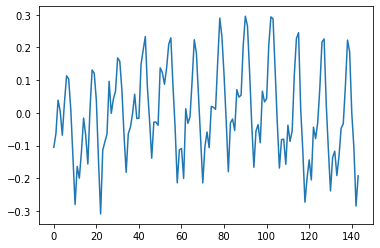

In [38]:
plot_timeseries(detrended)

In [56]:
decomp = seasonal_decompose(df['Passengers'],model='additive')

In [57]:
residuals = decomp.resid

In [58]:
residuals = residuals.fillna(method='ffill')
residuals = residuals.fillna(method='bfill')

In [59]:
adfuller(residuals)

(-5.445925988180048,
 2.710708269381098e-06,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 949.7723330380389)

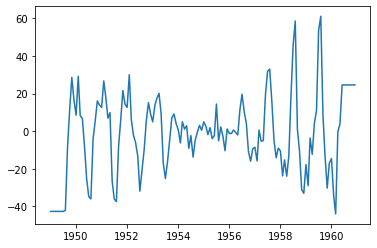

In [60]:
plot_timeseries(residuals)

Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

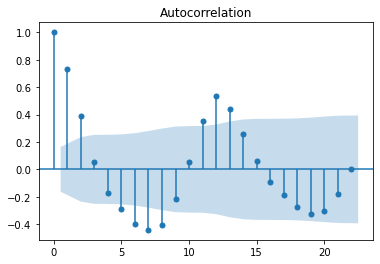

In [62]:
plot_acf(residuals)
plt.show()

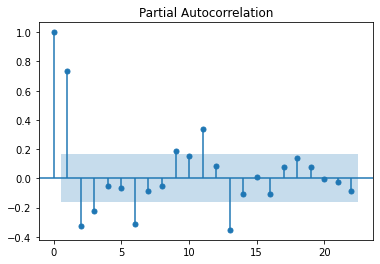

In [63]:
plot_pacf(residuals)
plt.show()

Plot the predictions (not transformed to the original scale)

In [69]:
from sklearn import metrics

In [70]:
size = int(len(residuals) * 0.66)
train, test = residuals[0:size], residuals[size:len(residuals)]
history = [x for x in train]

Test RMSE: 16.530


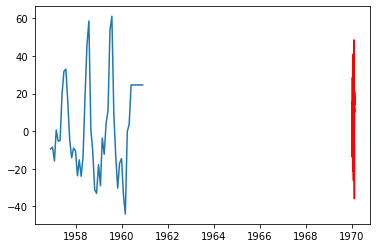

In [75]:
# model = ARIMA(x_train,order=(1,0,2))
# model.fit()
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(metrics.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


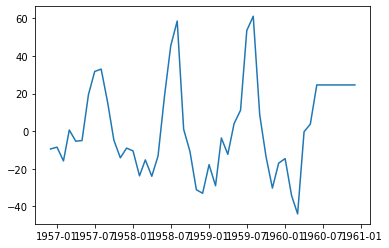

In [76]:
plt.plot(test)

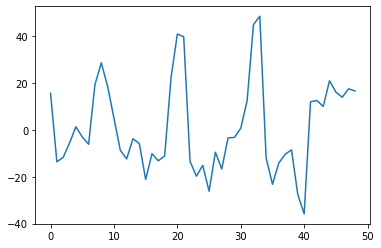

In [77]:
plt.plot(predictions)

Plot the predictions (transformed to the original scale)

Plot the predictions for the next 10 years